# Imports

In [2]:
# CapyMoa
from capymoa.datasets import Electricity, Covtype, Fried
from capymoa.evaluation import ClassificationEvaluator, ClassificationWindowedEvaluator, prequential_evaluation, prequential_evaluation_multiple_learners
from capymoa.classifier import OnlineBagging, HoeffdingTree, KNN
from capymoa.evaluation.visualization import plot_windowed_results

# River
from river.evaluate import progressive_val_score
from river.stream import iter_sklearn_dataset
from river.metrics import Accuracy

from river.naive_bayes import GaussianNB
from river.tree import HoeffdingTreeClassifier
from river.ensemble import BaggingClassifier
from river.neighbors import KNNClassifier

# Scikit learn
from sklearn import preprocessing, model_selection, datasets, metrics

# Miscellaneous for tracking
import time, tracemalloc, psutil

# Utils

In [6]:
# Generator to yield (x_dict, y) in river format
def capymoa_to_river_stream(stream):
    feature_names = stream.get_schema().get_numeric_attributes()
    for instance in stream:
        x_dict = dict(zip(feature_names, instance.x))
        y = instance.y_index  # or instance.y if using class label
        yield x_dict, y

# Start measurements
def start_measurements():
    tracemalloc.start()
    start_time = time.time()
    cpu_start = psutil.cpu_percent(interval=None)
    return start_time, cpu_start

def end_measurements():
    end_time = time.time()
    cpu_end = psutil.cpu_percent(interval=None)
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return end_time, cpu_end, current, peak

# CapyMOA


--- Performance Summary ---
Accuracy: {'OB': <capymoa.evaluation.results.PrequentialResults object at 0x1c1a35110>, 'HT': <capymoa.evaluation.results.PrequentialResults object at 0x1c1aaae50>, 'KNN': <capymoa.evaluation.results.PrequentialResults object at 0x1c1aa8910>}
Total Time: 16.58 seconds
CPU Usage: 30.4%
Peak Memory Usage: 0.10 MB


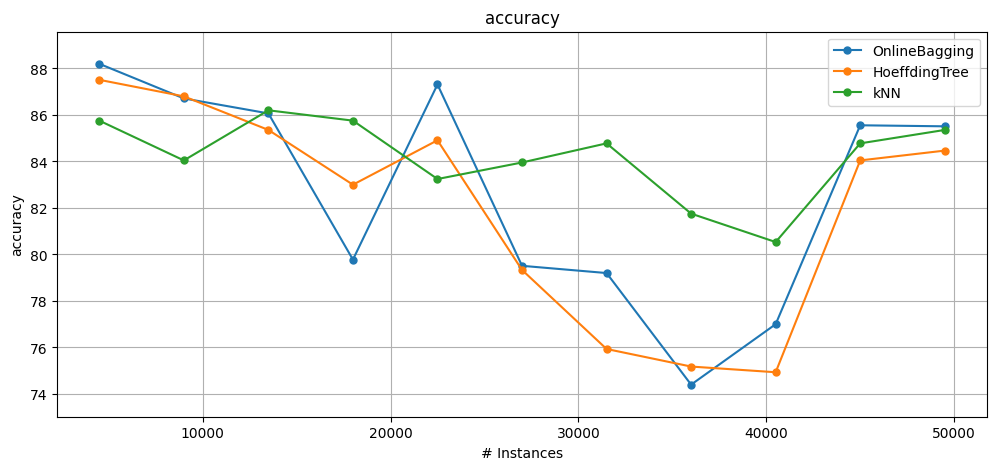

In [ ]:
stream = Electricity()

# Define the learners + an alias (dictionary key)
learners = {
    "OB": OnlineBagging(schema=stream.get_schema(), ensemble_size=10),
    "HT": HoeffdingTree(schema=stream.get_schema()),
    "KNN": KNN(schema=stream.get_schema(), k=3),
}

start_time, cpu_start = start_measurements()

results = prequential_evaluation_multiple_learners(stream, learners, window_size=4500)

end_time, cpu_end, current, peak = end_measurements()

print(f"\n--- Performance Summary ---")
print(f"Total Time: {end_time - start_time:.2f} seconds")
print(f"CPU Usage: {cpu_end}%")
print(f"Peak Memory Usage: {peak / 10**6:.2f} MB")

plot_windowed_results(results["OB"], results["HT"], results['KNN'],  metric="accuracy")